In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install bokeh
#!pip install numpy
#!pip install sklearn
#!pip install tqdm
#!pip install librosa
#!pip install tensorflow


In [3]:
import glob
import os
import warnings
import numpy as np
from bokeh.io import export_svgs, output_notebook
from bokeh.models import BoxAnnotation, ColumnDataSource, HoverTool
from bokeh.plotting import figure, show
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from utils.measuring_performance import (
    get_prediction,
    plot_confusion_matrix,
    plot_histogram_by_class,
    plot_loss_per_epoch,
    plot_pr_curve,
    plot_roc_curve,
)
from utils.misc import build_files_list, dump_pickle, load_pickle
from utils.sound_utils import extract_signal_features, generate_dataset, load_sound_file

output_notebook()
warnings.filterwarnings("ignore")
np.random.seed(42)

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Loading BokehJS ...

In [4]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
#from tensorflow.python.keras.utils.multi_gpu_utils import multi_gpu_model
#from tensorflow.keras.utils import multi_gpu_model
from tensorflow.python.client import device_lib

tf.random.set_seed(42)

2022-08-24 14:48:46.370278: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-24 14:48:46.370307: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
def get_available_gpus():
    local_devices = device_lib.list_local_devices()
    return [x.name for x in local_devices if x.device_type == "GPU"]

The boolean variable `COMBINE_MACHINE_ID` allows you to decide whether to perform modeling separately for each machine ID, or combine all data from the same machine type to perform modeling.

In [6]:
# Specify path to the folders
DATA_PATH = "../../data/mimii-anomaly-detection"
IMAGE_PATH = "./img"
MODEL_PATH = "./models"
MERGE_MACHINE_ID = True

os.makedirs(os.path.join(DATA_PATH, "dataset"), exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)

file_paths = sorted(
    glob.glob(DATA_PATH + "/*/*" if MERGE_MACHINE_ID else DATA_PATH + "/*/*/*")
)

# Data Splitting and Preprocessing

In [7]:
file_path = file_paths[0]  # the first machine ID or machine type selected
file_path_split = file_path.split("/")
SUFFIX = "_".join(["", file_path_split[-1], file_path_split[-2]])

if MERGE_MACHINE_ID:
    print(f"db: {file_path_split[-2]}, machine type: {file_path_split[-1]}")

else:
    print(
        f"db: {file_path_split[-3]}, machine type: {file_path_split[-2]}, machine id: {file_path_split[-1]}"
    )
    SUFFIX = "_".join([SUFFIX, file_path_split[-3]])

db: 6dB, machine type: fan


Because unsupervised learning is used, all anomalous labels are assigned to the test set.

In [8]:
normal_files, abnormal_files = build_files_list(root_dir=file_path)
normal_labels = np.zeros(len(normal_files))
abnormal_labels = np.ones(len(abnormal_files))
print(normal_labels)
print(abnormal_labels)

[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]


In [9]:
print(len(abnormal_files))

1475


In [10]:
train_files, test_files, train_labels, test_labels = train_test_split(
    normal_files, normal_labels, train_size=0.8, random_state=42, shuffle=True
)
print("Example train file path: ", train_files[500])
print("Amount of train files", len(train_files))
print("Unique value counts of train labels", np.unique(train_labels, return_counts=True))
print(len(train_labels))
print("---------------")
print("Example test file path: ", test_files[500])
print("Amount of test files", len(test_files))
print("Unique value counts of test labels", np.unique(test_labels, return_counts=True))

Example train file path:  ../../data/mimii-anomaly-detection/6dB/fan/id_02/normal/00000141.wav
Amount of train files 3260
Unique value counts of train labels (array([0.]), array([3260]))
3260
---------------
Example test file path:  ../../data/mimii-anomaly-detection/6dB/fan/id_06/normal/00000660.wav
Amount of test files 815
Unique value counts of test labels (array([0.]), array([815]))


In [11]:
# Add abnormal sounds to the test files
test_files = np.concatenate((test_files, abnormal_files), axis=0)
test_labels = np.concatenate((test_labels, abnormal_labels), axis=0)
print("Amount of test files:" , len(test_files))
print("Unique value counts of test labels", np.unique(test_labels, return_counts=True))
print("Amount of test files:" , len(test_labels))

Amount of test files: 2290
Unique value counts of test labels (array([0., 1.]), array([ 815, 1475]))
Amount of test files: 2290


In [12]:
# Shuffle indices in test files
test_indices = np.arange(len(test_files))
np.random.shuffle(test_indices)
print(test_indices)
print(len(test_indices))

[2178 1271 1268 ... 1130 1294  860]
2290


In [13]:
test_files = test_files[test_indices]
test_labels = test_labels[test_indices]

print(
    f"Train set has {train_labels.shape[0]} signals including {train_labels.sum():.0f} abnormal signals, \
but test set has {test_labels.shape[0]} signals including {test_labels.sum():.0f} abnormal signals."
)

Train set has 3260 signals including 0 abnormal signals, but test set has 2290 signals including 1475 abnormal signals.


In [14]:
print("Example train file path", train_files[3])
print("Amount of trains files" ,len(train_files))
print("Unique values of train labels: ", np.unique(train_labels, return_counts=True))
print("-------------")
print("Amount of test files" ,len(test_files))
print("Unique values of train labels: ", np.unique(test_labels, return_counts=True))

Example train file path ../../data/mimii-anomaly-detection/6dB/fan/id_06/normal/00000645.wav
Amount of trains files 3260
Unique values of train labels:  (array([0.]), array([3260]))
-------------
Amount of test files 2290
Unique values of train labels:  (array([0., 1.]), array([ 815, 1475]))


In [15]:
dataset = {
    "train_files": train_files,
    "test_files": test_files,
    "train_labels": train_labels,
    "test_labels": test_labels,
}

# Save metadata to .txt file
for key, values in dataset.items():
    file_name = os.path.join(DATA_PATH, "dataset", key + SUFFIX + ".txt")
    with open(file_name, "w") as f:
        for item in values:
            f.write(str(item) + "\n")

In [16]:
len(train_files), len(train_labels), len(test_files)

(3260, 3260, 2290)

In [17]:
# this is the number of samples in a window per fft
n_fft = 2048
# The amount of samples we are shifting after each fft
hop_length = 512
# number of Mel bands to generate
n_mels = 64
frames = 5

train_data_path = os.path.join(DATA_PATH, "dataset", "train_data" + SUFFIX + ".pkl")

if os.path.exists(train_data_path):
    print("Train data already exists, loading from file...")
    train_data = load_pickle(train_data_path)

else:
    train_data = generate_dataset(
        train_files, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, frames=frames
    )
    print("Saving train data to disk...")
    # Serialize object
    dump_pickle(train_data_path, train_data)
    print("Done.")

print(f"Train data has a {train_data.shape} shape.")

  0%|          | 0/3260 [00:00<?, ?it/s]

Saving train data to disk...
Done.
Train data has a (1007340, 320) shape.


In [18]:
# # DEBUG
# # this is the number of samples in a window per fft
# n_fft = 2048
# # The amount of samples we are shifting after each fft
# hop_length = 512
# # number of Mel bands to generate
# n_mels = 64
# frames = 5

# import librosa
# print("Range of files to iterate" , range(len(train_files)))
# signal, sr = load_sound_file(train_files[15])
# print("Example feature of train files:", signal, sr)
# print("Sample rate 16000 means that there are 16000 samples for every 1 second")
# print("------AFTER EXTRACT_SIGNAL_FEATURES-----")
# print("Create mel_spectogram")
# mel_spectrogram = librosa.feature.melspectrogram(
#         y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
#     )
# print("Mel_spectogram shape", mel_spectrogram.shape)
# print("Create log_mel_spectogram")
# log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
# print("log_mel_spectogram shape", log_mel_spectrogram.shape)
# features_vector_size = log_mel_spectrogram.shape[1] - frames + 1
# print("Features vector_size: ", features_vector_size)
# dims = frames * n_mels
# print("Dims: ", dims)
# features = np.zeros((features_vector_size, dims), np.float32)
# print("features shape and uinque values", features.shape, np.unique(features))
# for time in range(frames):
#         features[:, n_mels * time : n_mels * (time + 1)] = log_mel_spectrogram[
#             :, time : time + features_vector_size
#         ].T

In [76]:
# for time in range(frames):
#     print(time)
#     print(n_mels * time)
#     print(n_mels * (time + 1))
#     print((log_mel_spectrogram[:, time : time + features_vector_size].T).shape)
#     print("----")
#     features[:, n_mels * time : n_mels * (time + 1)] = \
#         log_mel_spectrogram[:, time : time + features_vector_size].T
#     print(features[:, n_mels * time : n_mels * (time + 1)])
#     print("----")

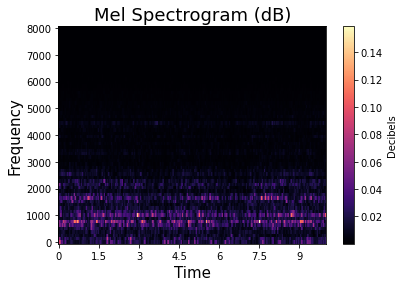

In [45]:
# DEBUG
import librosa, librosa.display
import matplotlib.pyplot as plt
# Using librosa.display.specshow() to create our spectrogram
librosa.display.specshow(mel_spectrogram, sr=sr, x_axis='time', y_axis='hz', hop_length=hop_length, cmap='magma')
plt.colorbar(label='Decibels')
plt.title('Mel Spectrogram (dB)', fontdict=dict(size=18))
plt.xlabel('Time', fontdict=dict(size=15))
plt.ylabel('Frequency', fontdict=dict(size=15))
plt.show()

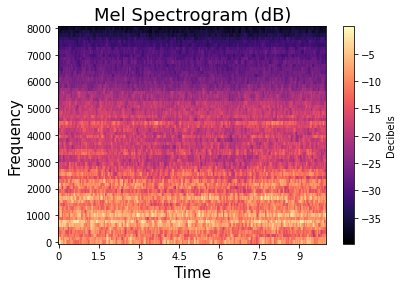

In [46]:
librosa.display.specshow(log_mel_spectrogram, sr=sr, x_axis='time', y_axis='hz', hop_length=hop_length, cmap='magma')
plt.colorbar(label='Decibels')
plt.title('log Mel Spectrogram (dB)', fontdict=dict(size=18))
plt.xlabel('Time', fontdict=dict(size=15))
plt.ylabel('Frequency', fontdict=dict(size=15))
plt.show()

In [ ]:
# Debug
def generate_dataset2(files_list, n_fft=1024, hop_length=512, n_mels=64, frames=5):
    dims = n_mels * frames
    
    # https://github.com/tqdm/tqdm - progress bar
    # Iterate over files list
    for index in tqdm(range(len(files_list))):
        #Load an audio file as a floating point time series
        signal, sr = load_sound_file(files_list[index])
        # First create mel_spectogram
        # https://importchris.medium.com/how-to-create-understand-mel-spectrograms-ff7634991056
        features = extract_signal_features(
            signal,
            sr,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels,
            frames=frames,
        )

        if index == 0:
            dataset = np.zeros((features.shape[0] * len(files_list), dims), np.float32)

        dataset[
            features.shape[0] * index : features.shape[0] * (index + 1), :
        ] = features

    return dataset

train_data = generate_dataset2(
        train_files, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, frames=frames
    )

In [ ]:
# print(len(train_data))
# print(train_data[2])
# print(len(train_data[2]))

# Model Training and Prediction with AutoEncoder

In [19]:
def autoencoder(input_dims, model_name=None):
    input_layer = Input(shape=(input_dims,))
    output = Dense(64, activation="relu")(input_layer)
    output = Dense(64, activation="relu")(output)
    output = Dense(8, activation="relu")(output)
    output = Dense(64, activation="relu")(output)
    output = Dense(64, activation="relu")(output)
    output = Dense(input_dims, activation=None)(output)

    return Model(inputs=input_layer, outputs=output, name=model_name)

In [21]:
print("input_dims", n_mels * frames)

input_dims 320


In [20]:
from tensorflow.python.client import device_lib
MODEL_NAME = "AutoEncoder"
model = autoencoder(n_mels * frames, model_name=MODEL_NAME)
print(model.summary())

print(f"n_mels = {n_mels}, frames = {frames}")

gpu_count = len(get_available_gpus())
print(f"Available gpus = {gpu_count}")
if gpu_count > 1:
    model = multi_gpu_model(model, gpus=gpu_count)

Model: "AutoEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320)]             0         
                                                                 
 dense (Dense)               (None, 64)                20544     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 64)                576       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 320)               

2022-08-24 14:51:39.657560: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-24 14:51:39.657588: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (iotg): /proc/driver/nvidia/version does not exist
2022-08-24 14:51:39.657849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [1]:
# import matplotlib.pyplot as plt
# fig = plt.figure(figsize=(10, 5))
# plt.plot(
#     train_data[15], label="Machine #id_00 - Normal Signal"
# )
# plt.title(
#     f"Short"
# )
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("Amplitude")
# plt.legend()
# plt.xlim(0, 200)
# plt.show()

In [46]:
train_data[15].shape

(320,)

In [22]:
batch_size = 256
epochs = 20

model.compile(
    optimizer=Adam(learning_rate=1e-03),
    loss="mean_squared_error"
)

In [23]:
%%time
history = model.fit(
    train_data,
    train_data,
    batch_size=batch_size,
    epochs=epochs,
    verbose=True,
    # https://keras.io/api/callbacks/early_stopping/
    callbacks=[EarlyStopping(monitor="val_loss", patience=10)],
    validation_split=0.1,
    shuffle=True
)

#model.save(os.path.join(MODEL_PATH, MODEL_NAME + SUFFIX + ".h5"))

Epoch 1/20
3542/3542 [==============================] - 10s 3ms/step - loss: 7.7231 - val_loss: 3.9054
Epoch 2/20
3542/3542 [==============================] - 9s 3ms/step - loss: 3.7674 - val_loss: 3.8229
Epoch 3/20
3542/3542 [==============================] - 9s 3ms/step - loss: 3.6935 - val_loss: 3.7451
Epoch 4/20
3542/3542 [==============================] - 9s 3ms/step - loss: 3.5593 - val_loss: 3.6139
Epoch 5/20
3542/3542 [==============================] - 9s 3ms/step - loss: 3.5014 - val_loss: 3.6185
Epoch 6/20
3542/3542 [==============================] - 9s 3ms/step - loss: 3.4676 - val_loss: 3.5615
Epoch 7/20
3542/3542 [==============================] - 9s 3ms/step - loss: 3.4210 - val_loss: 3.4774
Epoch 8/20
3542/3542 [==============================] - 9s 3ms/step - loss: 3.3637 - val_loss: 3.4348
Epoch 9/20
3542/3542 [==============================] - 9s 2ms/step - loss: 3.3287 - val_loss: 3.3973
Epoch 10/20
3542/3542 [==============================] - 9s 3ms/step - loss: 3.30

In [28]:
#!pip install selenium

In [24]:
plot_loss_per_epoch(
    history, model_name=MODEL_NAME, file_name=os.path.join(IMAGE_PATH, "model_loss.svg")
)

In [25]:
recon_errors = []

for index in tqdm(range(len(test_files))):
    signal, sr = load_sound_file(test_files[index])

    features = extract_signal_features(
        signal, sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, frames=frames
    )

    predictions = model.predict(features)
    # https://medium.com/nothingaholic/understanding-the-mean-squared-error-df41e2c87958
    mse = np.mean(np.mean(np.square(features - predictions), axis=1))
    recon_errors.append(mse)

  0%|          | 0/2290 [00:00<?, ?it/s]

10/10 [==============================] - 0s 802us/step


10/10 [==============================] - 0s 985us/step


10/10 [==============================] - 0s 920us/step


10/10 [==============================] - 0s 973us/step


10/10 [==============================] - 0s 832us/step


10/10 [==============================] - 0s 810us/step


10/10 [==============================] - 0s 807us/step


10/10 [==============================] - 0s 788us/step


10/10 [==============================] - 0s 783us/step


10/10 [==============================] - 0s 818us/step


10/10 [==============================] - 0s 771us/step


In [27]:
#print(recon_errors)
#print(features[0])

In [28]:
print(len(features[0]))

320


# Model Evaluation

In [29]:
stack = np.column_stack((range(len(recon_errors)), recon_errors))
score_false = stack[test_labels == 0][:, 1]
score_true = stack[test_labels == 1][:, 1]

plot_histogram_by_class(
    score_false,
    score_true,
    bins=[20, 30],
    model_name=MODEL_NAME,
    file_name=os.path.join(IMAGE_PATH, "recon_error_dist.svg"),
)

In [32]:
THRESHOLD_MIN = 2.0
THRESHOLD_MAX = 7.0

p = figure(
    plot_width=600,
    plot_height=400,
    title=f"Autoenkoder: błąd rekonstrukcji ",
    x_axis_label="Próbki",
    y_axis_label="Błąd rekonstrukcji",
)

source = ColumnDataSource(
    dict(index=stack[test_labels == 0][:, 0], error=stack[test_labels == 0][:, 1])
)
p.scatter(
    "index",
    "error",
    fill_alpha=0.6,
    fill_color="crimson",
    line_color=None,
    legend_label="Normalny sygnał",
    source=source,
)

source = ColumnDataSource(
    dict(index=stack[test_labels == 1][:, 0], error=stack[test_labels == 1][:, 1])
)
p.scatter(
    "index",
    "error",
    fill_alpha=0.6,
    fill_color="indigo",
    line_color=None,
    legend_label="Anomalia",
    source=source,
)

source = ColumnDataSource(
    data=dict(
        index=stack[:, 0],
        threshold_min=np.repeat(THRESHOLD_MIN, stack.shape[0]),
        threshold_max=np.repeat(THRESHOLD_MAX, stack.shape[0]),
    )
)

box = BoxAnnotation(
    bottom=THRESHOLD_MIN,
    top=THRESHOLD_MAX,
    fill_alpha=0.1,
    fill_color="magenta",
    line_color="darkmagenta",
    line_width=1.0,
)
p.add_layout(box)

p.legend.label_text_font_size = "8pt"
p.legend.location = "top_right"
p.title.align = "center"
p.title.text_font_size = "12pt"

p.add_tools(HoverTool(tooltips=[("index", "@index"), ("error", "@error")]))
show(p)

p.output_backend = "svg"
_ = export_svgs(p, filename=os.path.join(IMAGE_PATH, "thr_range_exp.svg"))

In [33]:
THRESHOLD_STEP = 0.2
thresholds = np.arange(THRESHOLD_MIN, THRESHOLD_MAX + THRESHOLD_STEP, THRESHOLD_STEP)
errors = []

for threshold in thresholds:
    predictions = get_prediction(stack[:, 1], threshold=threshold)
    conf_mat = confusion_matrix(test_labels, predictions)
    errors.append([threshold, conf_mat[1, 0], conf_mat[0, 1]])

errors = np.array(errors)

In [34]:
p = figure(
    plot_width=600,
    plot_height=400,
    title=f"{MODEL_NAME}: Best Threshold Exploration",
    x_axis_label="Reconstruction Error Threshold (%)",
    y_axis_label="# Samples",
)

source = ColumnDataSource(
    data=dict(
        threshold=errors[:, 0], false_negative=errors[:, 1], false_positive=errors[:, 2]
    )
)

p.line(
    x="threshold",
    y="false_negative",
    color="crimson",
    legend_label="False Negative",
    source=source,
)
p.circle(
    x="threshold", y="false_negative", color="crimson", fill_color="white", source=source
)
p.line(
    x="threshold",
    y="false_positive",
    color="indigo",
    legend_label="False Positive",
    source=source,
)
p.circle(
    x="threshold", y="false_positive", color="indigo", fill_color="white", source=source
)

p.legend.label_text_font_size = "8pt"
p.legend.location = "top_left"
p.legend.click_policy = "hide"
p.title.align = "center"
p.title.text_font_size = "12pt"

p.add_tools(
    HoverTool(
        tooltips=[
            ("threshold", "@threshold"),
            ("false_negative", "@false_negative"),
            ("false_positive", "@false_positive"),
        ]
    )
)
show(p)

p.output_backend = "svg"
_ = export_svgs(p, filename=os.path.join(IMAGE_PATH, "best_thr_exp.svg"))

In [35]:
THRESHOLD = 3.6
predictions = get_prediction(stack[:, 1], threshold=THRESHOLD)

plot_confusion_matrix(
    confusion_matrix(test_labels, predictions),
    model_name=MODEL_NAME,
    file_name=os.path.join(IMAGE_PATH, "conf_mat.svg"),
)

In [36]:
print(
    f"Accuracy: {accuracy_score(test_labels, predictions):.2%}, \
Precision: {precision_score(test_labels, predictions):.2%}, \
Recall: {recall_score(test_labels, predictions):.2%}, \
F1: {f1_score(test_labels, predictions):.2%}"
)

Accuracy: 86.68%, Precision: 90.34%, Recall: 88.81%, F1: 89.57%


In [37]:
plot_roc_curve(
    roc_curve(test_labels, recon_errors),
    roc_auc_score(test_labels, recon_errors),
    model_name=MODEL_NAME
    #file_name=os.path.join(IMAGE_PATH, "roc_curve.svg"),
)

In [38]:
plot_pr_curve(
    precision_recall_curve(test_labels, recon_errors),
    average_precision_score(test_labels, recon_errors),
    model_name=MODEL_NAME
    #file_name=os.path.join(IMAGE_PATH, "pr_curve.svg"),
)